In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display

import seaborn as sns
%matplotlib inline

In [2]:
from nmt_run import *

  0%|          | 0/138708 [00:00<?, ?it/s]

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict
--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 633929.81it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1804
    1 |   256 |   1047
    2 |   512 |    559
    3 |   768 |    348
    4 |  1024 |    158
    5 |  1280 |     53
    6 |  1536 |      6
    7 |  1792 |      2
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1656
    1 |   256 |   1177
    2 |   512 |    546
    3 |   768 |    363
    4 |  1024 |    150
    5 |  1280 |     50
    6 |  1536 |     16
    7 | 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model
loading ...
finished loading ..


In [7]:
import nltk.translate.bleu_score

### Fisher

In [8]:
key='fisher_train'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [9]:
list(m_dict.keys())[:5]

['20050908_182943_22_fsp-A-1',
 '20050908_182943_22_fsp-B-1',
 '20050908_182943_22_fsp-A-2',
 '20050908_182943_22_fsp-B-2',
 '20050908_182943_22_fsp-A-3']

In [10]:
en_words = []
_ = [en_words.extend(w['en_w']) for w in m_dict.values()]

es_words = []
_ = [es_words.extend(w['es_w']) for w in m_dict.values()]

In [11]:
len(en_words), len(set(en_words)), len(es_words), len(set(es_words))

(1496722, 18551, 1496747, 33718)

In [12]:
def create_vocab(word_list, prune_freq=0):
    vocab = {}
    for w in word_list:
        if w in vocab:
            vocab[w] += 1
        else:
            vocab[w] = 1
    # end for
    
    # prune 
    vocab = {k:v for k,v in vocab.items() if v >= prune_freq}
    return vocab

In [13]:
en_vocab = create_vocab(en_words, prune_freq=1)
es_vocab = create_vocab(es_words)

In [14]:
en_words_pruned = [w for w in en_words if w in en_vocab]

In [15]:
np.max([len(w) for w in en_vocab])

24

In [16]:
len_range = (np.min([len(w) for w in en_vocab]), np.max([len(w) for w in en_vocab]))

In [17]:
len_range

(1, 24)

In [18]:
x = np.array([len(w) for w in en_words_pruned])
len_counts = {i:0 for i in range(1,np.max(x)+1,1)}

for i in x:
    len_counts[i] += 1

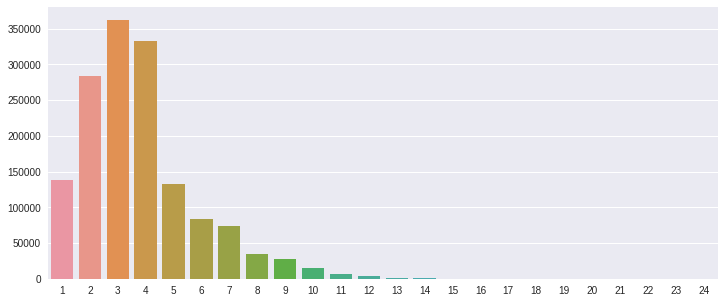

In [19]:
plt.figure(figsize=(12,5))
_ = sns.barplot(x=list(len_counts.keys()), y = list(len_counts.values()))

In [20]:
# os.chdir(".."k,v)
# os.chdir("chainer2/speech2text")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/chainer2/speech2text")

In [21]:
en_words_by_len = {i: set([w for w in en_vocab if len(w) ==  i]) for i in range(1,np.max(x)+1,1)}
en_word_counts_by_len = {i: [w for w in en_words_pruned if len(w) ==  i] for i in range(1,np.max(x)+1,1)}

In [22]:
start_len = 12
total_words_above_len = 0
total_word_counts_above_len = 0
for i in range(start_len,np.max(x)+1,1):
    total_words_above_len += len(en_words_by_len[i])
    total_word_counts_above_len += len(en_word_counts_by_len[i])
    print("{0:5d} | {1:5d} | {2:5d} | {3:5d}".format(i, 
                                                     len(en_words_by_len[i]), 
                                                     total_words_above_len,
                                                     total_word_counts_above_len))

print("\ntotal english words={0:d}".format(len(en_words_pruned)))

# start_len = 15
# total_word_counts_above_len = 0
# for i in range(start_len,np.max(x)+1,1):
#     total_word_counts_above_len += len(en_word_counts_by_len[i])
#     print("{0:5d} | {1:5d} | {2:5d}".format(i, len(en_words_by_len[i]), total_word_counts_above_len))
# print(total_word_counts_above_len)



   12 |   486 |   486 |  3696
   13 |   292 |   778 |  5463
   14 |   134 |   912 |  5949
   15 |    60 |   972 |  6101
   16 |    18 |   990 |  6138
   17 |    12 |  1002 |  6155
   18 |     3 |  1005 |  6159
   19 |     1 |  1006 |  6161
   20 |     3 |  1009 |  6164
   21 |     0 |  1009 |  6164
   22 |     0 |  1009 |  6164
   23 |     1 |  1010 |  6165
   24 |     1 |  1011 |  6167

total english words=1496722


In [23]:
en_words_above_len = {k:v for k,v in en_vocab.items() if len(k) >= start_len}

In [24]:
max([(w,len(w)) for w in en_words_above_len], key=lambda t:t[1])

(b'great-great-grandparents', 24)

In [25]:
# from nltk.stem import *
# from nltk.stem.porter import *
# from nltk.stem.snowball import SnowballStemmer

In [26]:
# stemmer = PorterStemmer()
# stemmer = SnowballStemmer("english")
# lemmer = nltk.wordnet.WordNetLemmatizer()
from stemming.porter2 import stem
import stemming

In [28]:
stems_lems = [(w.decode("utf-8"), stem(w.decode("utf-8")), stem(w.decode("utf-8"))) for w in en_words_above_len]

In [30]:
stem('residencies'), stem('residencies')

('resid', 'resid')

In [31]:
en_word_stems = [stem(w.decode()) for w in en_vocab]

In [32]:
len(set(en_vocab.keys())), len(set(en_word_stems))

(18551, 12864)

In [33]:
en_word_stem_freq = {}
for w in en_vocab:
    if stem(w.decode()) not in en_word_stem_freq:
        en_word_stem_freq[stem(w.decode())] = [w.decode()]
    else:
        en_word_stem_freq[stem(w.decode())].append(w.decode())

In [34]:
en_word_stem_cats = sorted(en_word_stem_freq.items(), reverse=True, key=lambda t: len(t[1]))

In [35]:
display_pp = PrettyTable(["stem","words"], hrules=True)
display_pp.align = "l"
for stem, word_list in en_word_stem_cats:
    if len(word_list) > 1:
        display_pp.add_row([stem, textwrap.fill(", ".join(word_list),50)])

print(display_pp)

+------------------+----------------------------------------------------+
| stem             | words                                              |
+------------------+----------------------------------------------------+
| organ            | organizing, organize, organizations, organic,      |
|                  | organizers, organization, organized, organs,       |
|                  | organics, organism, organisms, organ, organizer,   |
|                  | organizes                                          |
+------------------+----------------------------------------------------+
| depend           | depends, depending, depend, dependent, depended,   |
|                  | dependes, dependence, dependency, dependencies,    |
|                  | dependable, dependant, dependents                  |
+------------------+----------------------------------------------------+
| celebr           | celebrated, celebrations, celebrate, celebration,  |
|                  | celebrating, cele

In [36]:
x = np.array([len(v) for k,v in en_word_stem_cats if len(v)>1])
len_counts = {i:0 for i in range(1,np.max(x)+1,1)}

for i in x:
    len_counts[i] += 1

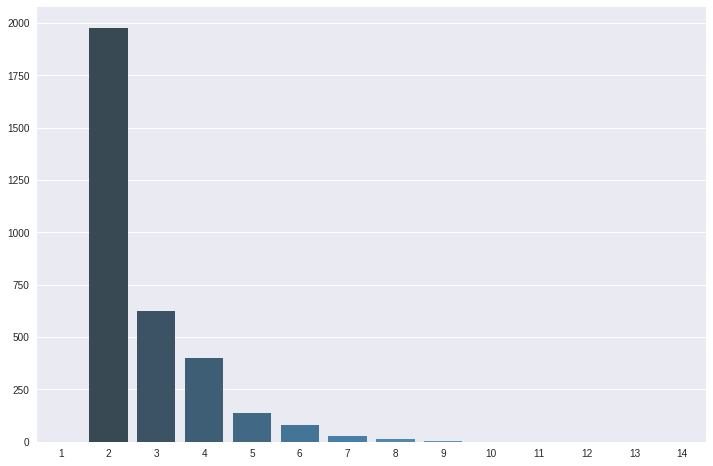

In [37]:
plt.figure(figsize=(12,8))
_ = sns.barplot(x=list(len_counts.keys()), y = list(len_counts.values()), palette="Blues_d")

In [38]:
sorted(stems_lems)

[('--everything', '--everyth', '--everyth'),
 ('[afternoon|evening]', '[afternoon|evening]', '[afternoon|evening]'),
 ('[interested]', '[interested]', '[interested]'),
 ('[merchandise]', '[merchandise]', '[merchandise]'),
 ('[pretty-small]', '[pretty-small]', '[pretty-small]'),
 ('[sugar-coated]', '[sugar-coated]', '[sugar-coated]'),
 ('aaparentemente', 'aaparentement', 'aaparentement'),
 ('academically', 'academ', 'academ'),
 ('accidentally', 'accident', 'accident'),
 ('accommodates', 'accommod', 'accommod'),
 ('accommodating', 'accommod', 'accommod'),
 ('accommodation', 'accommod', 'accommod'),
 ('accompaniments', 'accompani', 'accompani'),
 ('accomplished', 'accomplish', 'accomplish'),
 ('accomplishes', 'accomplish', 'accomplish'),
 ('accomplishment', 'accomplish', 'accomplish'),
 ('accountability', 'account', 'account'),
 ('accumulating', 'accumul', 'accumul'),
 ('acknowledged', 'acknowledg', 'acknowledg'),
 ('acknowledging', 'acknowledg', 'acknowledg'),
 ('acquaintances', 'acquain

In [ ]:
sorted(lem)

In [ ]:
m_dict['20050908_182943_22_fsp-A-1']['en_w']

In [ ]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, 200
displayN = 50

In [ ]:
display_words(m_dict, v_dict, fsh_pred_sents[:displayN], fsh_utts[:displayN], 
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

In [ ]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              fsh_pred_sents, 
                              fsh_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

# chrf = [0]*4

# for ref_i in range(4):
#     _, chrf[ref_i], _, _ = calc_bleu(m_dict, 
#                               v_dict, 
#                               fsh_pred_sents[:n], 
#                               fsh_utts[:n], 
#                               dec_key, 
#                               min_len=min_len, 
#                               max_len=max_len, 
#                               ref_index=ref_i)
#     # end for

# # print chrf score
# for i in range(4):
#     print("CHRF score on: {0:s} = {1:.2f}, using reference = {2:d}".format(key, chrf[i] * 100, i))

# print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
pred_path = "/afs/inf.ed.ac.uk/group/project/lowres/work/installs/fisher-callhome-corpus/corpus/ldc"
pred_fname = os.path.join(pred_path, "fisher_dev.pred")

In [ ]:
m_dict[fsh_utts[2]]['en_w']

In [ ]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_pred_sents, fsh_utts, dec_key, key, min_len=min_len, max_len=max_len)

In [ ]:
len(en_ref),len(en_hyp)

### Callhome dev

In [ ]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [ ]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
call_pred_sents, call_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
display_words(m_dict, v_dict, call_pred_sents[:displayN], call_utts[:displayN],
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

In [ ]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              call_pred_sents, 
                              call_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
call_en_ref, call_en_hyp = write_predictions_to_file(m_dict, v_dict, call_pred_sents, call_utts, 
                                                     dec_key, key, min_len=min_len, max_len=max_len)

In [ ]:
len(call_en_ref),len(call_en_hyp)

### Test code

In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)